# Import

In [6]:
from cartopy.crs import NorthPolarStereo, LambertAzimuthalEqualArea, Globe
import cartopy.feature as cfeature
from scipy.interpolate import RegularGridInterpolator
from datetime import date, datetime, timedelta
import glob
import sklearn.metrics as skm
from matplotlib.gridspec import GridSpec

import argparse
import numpy as np
from osgeo import gdal, osr, ogr
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# Functions

In [11]:
def get_gdal_dataset(x_ul, nx, dx, y_ul, ny, dy, srs_proj4, dtype=gdal.GDT_Float32):
    """
    Get empty gdal dataset with a given extent and projection

    Parameters:
    -----------
    x_ul : float
        x coordinates of upper-left corner of upper-left pixel
        ([0,0] pixel)
    nx   : int
        number of pixels in x-direction (number of columns)
    dx   : float
        step size in x direction (as column index increases)
        (can be negative)
    y_ul : float
        y coordinates of upper-left corner of upper-left pixel
        ([0,0] pixel)
    ny   : int
        number of pixels in y-direction (number of rows)
    dy   : float
        step size in y direction (as row index increases)
        (can be negative)

    Returns:
    --------
    ds : osgeo.gdal.Dataset
    """

    # create dataset
    dst_ds = gdal.GetDriverByName('MEM').Create('tmp', nx, ny, 1, dtype)

    # set grid limits
    # - for usage of osgeo.gdal.Dataset.SetGeoTransform, see:
    #   https://gdal.org/tutorials/geotransforms_tut.html
    dst_ds.SetGeoTransform((x_ul, dx, 0, y_ul, 0, dy))

    # set projection
    srs = osr.SpatialReference()
    srs.ImportFromProj4(str(srs_proj4))
    srs_wkt = srs.ExportToWkt()
    dst_ds.SetProjection(srs_wkt)

    # set no_data_value for the band
    band = dst_ds.GetRasterBand(1)
    NoData_value = -999999
    band.SetNoDataValue(NoData_value)
    band.FlushCache()

    return dst_ds

def rasterize_icehart(shapefile, ds):
    field_names = ['CT', 'CA', 'CB', 'CC', 'SA', 'SB', 'SC', 'FA', 'FB', 'FC']
    field_arr = []

    ivector = ogr.Open(shapefile, 0)
    ilayer = ivector.GetLayer()

    odriver = ogr.GetDriverByName('MEMORY')
    ovector = odriver.CreateDataSource('memData')
    olayer = ovector.CopyLayer(ilayer, 'burn_ice_layer', ['OVERWRITE=YES'])
    fidef = ogr.FieldDefn('poly_index', ogr.OFTInteger)
    olayer.CreateField(fidef)
    for ft in olayer:
        ft_id = ft.GetFID() + 1
        field_vec = [ft_id] + [float(ft.GetField(field_name)) for field_name in field_names]
        field_arr.append(field_vec)
        ft.SetField('poly_index', ft_id)
        olayer.SetFeature(ft)

    gdal.RasterizeLayer(ds, [1], olayer, options=["ATTRIBUTE=poly_index"])
    dst_arr = ds.ReadAsArray()
    return dst_arr, np.array(field_arr)


def SI_type(stage):
    
    index_ = 0
    
    if stage ==0:
        index_ = 0
    #print('ice_free')

    if stage in range(81,86):
        #print('Young ice')
        index_=1
    if stage in range(86,94):
        #print('First year ice')
        index_=2
    if stage in range(95,98):
        #print('multiyear ice')
        index_=3
    return index_


def ice_type_map(polyindex_arr, icecodes):    
    it_array = np.zeros(polyindex_arr.shape, float)
    it_array[:] = -1

    polyids = np.unique(polyindex_arr)


    for polyid in polyids:
        mask = polyindex_arr == polyid
        i = np.where(icecodes[:,0] == polyid)[0]
        if i:
            #if icecodes[i,1] >= 10 :
            ice = np.argmax([icecodes[i,2], icecodes[i,3], icecodes[i,4]])
            sod = [icecodes[i,5], icecodes[i,6], icecodes[i,7]]
            ice_type = SI_type(sod[ice])

            #ct = icecodes[i,1]
            it_array[mask] = ice_type
    return it_array


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


def weekrange(end_date):
    for n in range(6):
        yield end_date - timedelta(n)


def week_auto_files(str_date, path_aut):
    d = str_date.split('-')
    end_date = date(int(d[0]), int(d[1]), int(d[2]))
    aut_files = []

    for single_date in weekrange(end_date):
        print(single_date.strftime("%Y-%m-%d"))
        day = single_date.strftime("%d")
        month = single_date.strftime("%m")
        year = single_date.strftime("%Y")

        aut_file = sorted(glob.glob(path_aut + year + '/' + month + '/s1_icetype_mosaic_'+year+month+day+'0600.nc')) 
        aut_files.append(aut_file[0])
        
    return aut_files


def mosaic_auto_argmax(aut_files):
    with Dataset(aut_files[5]) as ds:
        n, m = ds ['ice_type'][0].filled(0).shape

    maps = []
    prob = []

    for file in aut_files:
        with Dataset(file) as ds:
            ice_type = ds['ice_type'][0].filled(4)
            confidence = ds['confidence'][0]
            ice_type[confidence == 0] = 4
            ice_type[ice_type == -1] = 4

        maps.append(ice_type)
        prob.append(confidence)
        
    cols, rows = np.meshgrid(range(m), range(n))
    sum_prob = np.zeros((n,m,4))

    for p, m in zip(prob, maps):
        gpi = m < 4
        sum_prob[rows[gpi], cols[gpi], m[gpi]] += p[gpi]
        
    max_prob_idx = np.argmax(sum_prob, axis=2)

    max_prob_idx[sum_prob.sum(axis=2) == 0] = -1
    
    return max_prob_idx


def is_difference (mosaic_aut, usice_inter):
    mask_aut = mosaic_aut >= 0
    mask_usnic = usice_inter >= 0
    mask_common = mask_aut * mask_usnic

    res_aut = mosaic_aut * mask_common
    res_usnic = usice_inter * mask_common
    res_usnic = np.nan_to_num(res_usnic, nan=0)

    diff_us_aut = res_usnic - res_aut
    return diff_us_aut, res_aut, res_usnic, mask_common


def compute_stats_us_aut (man2aut, res_man, res_aut, mask_diff):
    
    m_man = res_man[mask_diff]
    m_aut = res_aut[mask_diff]
    
    # basic metric  
    report = skm.classification_report(m_man, m_aut, digits=3, output_dict=True)
    
    accuracy = report['accuracy']
    macro_avg_p = report['macro avg']['precision']
    macro_avg_r = report['macro avg']['recall']
    macro_avg_f = report['macro avg']['f1-score']
    
    weighted_avg_p = report['weighted avg']['precision']
    weighted_avg_r = report['weighted avg']['recall']
    weighted_avg_f = report['weighted avg']['f1-score']
    
    # confusion matrix   
    matrix = skm.confusion_matrix(m_man, m_aut)
    
    # jaccard    possibly ok
    jaccard_labels = skm.jaccard_score(m_man, m_aut, average=None)   # list
    jaccard_avg = skm.jaccard_score(m_man, m_aut, average='weighted')  #float
    
    # Kappa    ok
    kappa = skm.cohen_kappa_score(m_man, m_aut, labels=None, weights=None, sample_weight=None)
    
    # Precision recall fscore   ok                 list
    p, r, f, s = skm.precision_recall_fscore_support(m_man, m_aut, average=None, warn_for=('precision', 'recall', 'f-score'))

    # matthews_corrcoef    ok
    mcc = skm.matthews_corrcoef(m_man, m_aut)
    
    # hamming_loss    possibly ok
    hloss = skm.hamming_loss(m_man, m_aut)
    
    # balanced accuracy
    b_acc = skm.balanced_accuracy_score(m_man, m_aut)
    
    # Count px in comparison, manual and automatic images

    total_man = []
    total_aut = []
    total = []
    ind = []

    for i in range (-3,4):
        count = np.count_nonzero(man2aut[mask_diff] == i)
        total.append(count)
        ind.append(i)

    for i in range (4):
        count_man = np.count_nonzero(res_man[mask_diff] == i)
        count_aut = np.count_nonzero(res_aut[mask_diff] == i)
        total_man.append(count_man)
        total_aut.append(count_aut)
    
    report_avg = [accuracy, macro_avg_p, macro_avg_r, macro_avg_f, weighted_avg_p, weighted_avg_r, weighted_avg_f]
    mat_lis = [p, r, f, s, matrix, jaccard_labels, total, total_man, total_aut] 
    indexes = [b_acc, hloss, mcc, kappa, jaccard_avg]
    
    datas = report_avg + mat_lis + indexes
    
    return datas


def write_stats_day(datas, path_stats, filename):
    
    with open(path_stats + filename + '.txt', "a") as file:
        
        for data in datas:
    
            #print(type(data))
    
            if type(data) == float or isinstance(data, np.float64):
                file.write(str(data) + "\n")

            if type(data) == list:
                count = ';'.join(map(str, data))
                file.write(count+"\n")

            if isinstance(data, np.ndarray):
                if data.ndim == 1:
                    count = ';'.join(map(str, data))
                    file.write(count+"\n")

            if isinstance(data, np.ndarray):
                if data.ndim == 2:
                    file.write("Confusion matrix\n")
                    rows = ["{};{};{};{}".format(i, j, k, l) for i, j, k, l in data]
                    conf = "\n".join(rows)
                    file.write(conf)
                    file.write("\n")


def image_render(year, month, day, path_img, man2aut, res_man, res_aut, land_mask, mask_diff):

    # adapt array with values for no data and land

    # difference between manual and automatic
    img = man2aut
    img[~mask_diff] = -4
    img[land_mask] = -5

    # manual
    img_man = res_man
    img_man[~mask_diff] = -1
    img_man[land_mask] = -2

    # automatic
    img_aut = res_aut
    img_aut[~mask_diff] = -1
    img_aut[land_mask] = -2


    # Colormap for comparison
    cmap = plt.cm.colors.ListedColormap(['gray','white' ,
                                         '#b30727', '#e8775d', '#f0cab7', '#cfd9e8', '#b5cdf8', '#6485ec', '#384abf'])
    # Colormap for ice type (from H.Boulze)
    cmap_hugo = plt.cm.colors.ListedColormap(['whitesmoke', 'white', '#0064ff', '#aa28f0', '#ffff00', '#b46432'])

    # Normalization of ice comparison
    norm = plt.Normalize(-5, 4)
    img_norm = norm(img)
    img_ = cmap(img_norm)

    # Normalization of ice types
    norm2 = plt.Normalize(-2,4)
    img_man_norm = norm2(img_man)
    img_man = cmap_hugo(img_man_norm)
    img_aut_norm = norm2(img_aut)
    img_aut = cmap_hugo(img_aut_norm)

    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 3, width_ratios=[4, 3, 3], height_ratios=[3, 3, 3])
    fig.suptitle("Ice comparison " + year + "-" + month + "-" + day, fontsize='x-large')

    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(img_, cmap=cmap, aspect='auto')
    ax1.set_title('Comparison')

    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(img_man, cmap=cmap_hugo, aspect='auto')
    ax2.set_title('Manual classification')

    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(img_aut, cmap=cmap_hugo, aspect='auto')
    ax3.set_title('Automatic classification')

    cbar_comp = plt.colorbar(im1, ax=ax1)

    cbar_comp.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['ground','no data','-3','-2', '-1', '0', '1', '2', '3']):
        cbar_comp.ax.text(1.3, (j + 0.5) / 9.0, lab, ha='left', va='center', fontsize='small')

    cbaxes = fig.add_axes([0.5, 0.62, 0.4, 0.02])
    cbar = plt.colorbar(im2, ax=[ax2, ax3], orientation='horizontal', cax = cbaxes)

    cbar.ax.get_xaxis().set_ticks([])
    for j, lab in enumerate(['Ground','No Data','Ice free','Young Ice', 'First Year Ice', 'Multi Year Ice']):
        cbar.ax.text((j + 0.5) / 6.0, .5, lab, ha='center', va='center', fontsize='small')

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()

    plt.savefig(path_img+"map_"+year+month+day+".png", dpi=300, bbox_inches='tight')
    

def nic_nersc_day(year, month, day, path_nic, path_nersc, path_stats):

    shapefile = path_nic + 'ARCTIC' + year[2:4] + month + day + '.shp'

    x_ul = -871516.0
    nx = 2800
    dx = 1000.0
    y_ul = 57017.0
    ny = 2500
    dy = -1000.0
    srs = '+proj=stere +lat_0=90.0 +lon_0=0.0 +lat_ts=90.0 +R=6.371e+06 +units=m +no_defs'

    # Rasterize the manual ice chart
    ds = get_gdal_dataset(x_ul, nx, dx, y_ul, ny, dy, srs, gdal.GDT_Int16)
    polyindex_arr, icecodes = rasterize_icehart(shapefile, ds)
    map_ice = ice_type_map(polyindex_arr, icecodes)

    # Mosaic the automatics files
    aut_files = week_auto_files(year + '-' + month + '-' + day, path_nersc)
    auto_mosaic = mosaic_auto_argmax(aut_files)

    with Dataset(aut_files[0]) as ds:
        land_mask = ds['ice_type'][0].filled(0) == -1

    # Make difference map
    diff_us_aut, res_aut, res_usnic, mask_common = is_difference (auto_mosaic, map_ice)

    # Compute all statistiques
    data = compute_stats_us_aut (diff_us_aut, res_usnic, res_aut, mask_common)

    # write statistics in a file
    filename = 'us_stats_' + year[2:4] + month + day
    write_stats_day(data, path_stats, filename)

    # Render image of maps
    image_render(year, month, day, path_stats, diff_us_aut, res_usnic, res_aut, land_mask, mask_common)
    

def nic_nersc_comparison(start_date, end_date, path_nic, path_nersc, path_stats):
    for single_date in daterange(start_date, end_date):
        #print(single_date.strftime("%Y-%m-%d"))
        day = single_date.strftime("%d")
        month = single_date.strftime("%m")
        year = single_date.strftime("%Y")
        path_nic_day = path_nic + 'Arctic_' + year + month + day + '/'
        
        man_file = sorted(glob.glob(path_nic_day + 'ARCTIC' + year[2:4] + month + day + '.shp'))
        if len(man_file) == 1:
            nic_nersc_day(year, month, day, path_nic_day, path_nersc, path_stats)
        


# Run

/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-01-13
2023-01-12
2023-01-11
2023-01-10
2023-01-09
2023-01-08


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-01-27
2023-01-26
2023-01-25
2023-01-24
2023-01-23
2023-01-22


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-02-10
2023-02-09
2023-02-08
2023-02-07
2023-02-06
2023-02-05


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-02-24
2023-02-23
2023-02-22
2023-02-21
2023-02-20
2023-02-19


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-03-10
2023-03-09
2023-03-08
2023-03-07
2023-03-06
2023-03-05


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-03-24
2023-03-23
2023-03-22
2023-03-21
2023-03-20
2023-03-19


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-04-21
2023-04-20
2023-04-19
2023-04-18
2023-04-17
2023-04-16


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-05-04
2023-05-03
2023-05-02
2023-05-01
2023-04-30
2023-04-29


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_118902/3212442738.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


2023-05-19
2023-05-18
2023-05-17
2023-05-16
2023-05-15
2023-05-14


/tmp/ipykernel_118902/3212442738.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


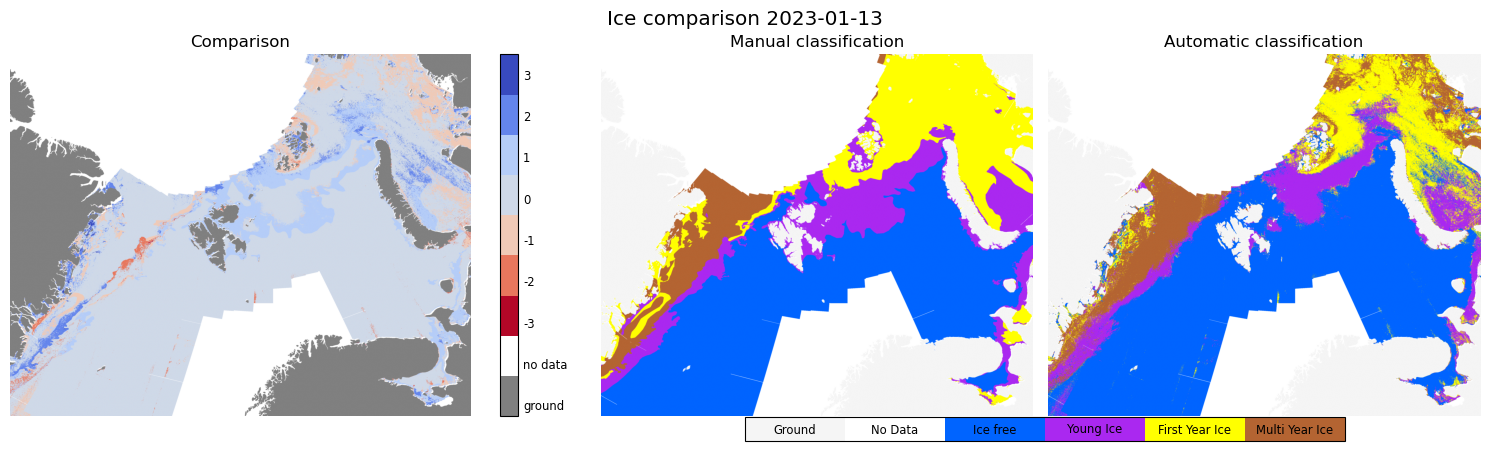

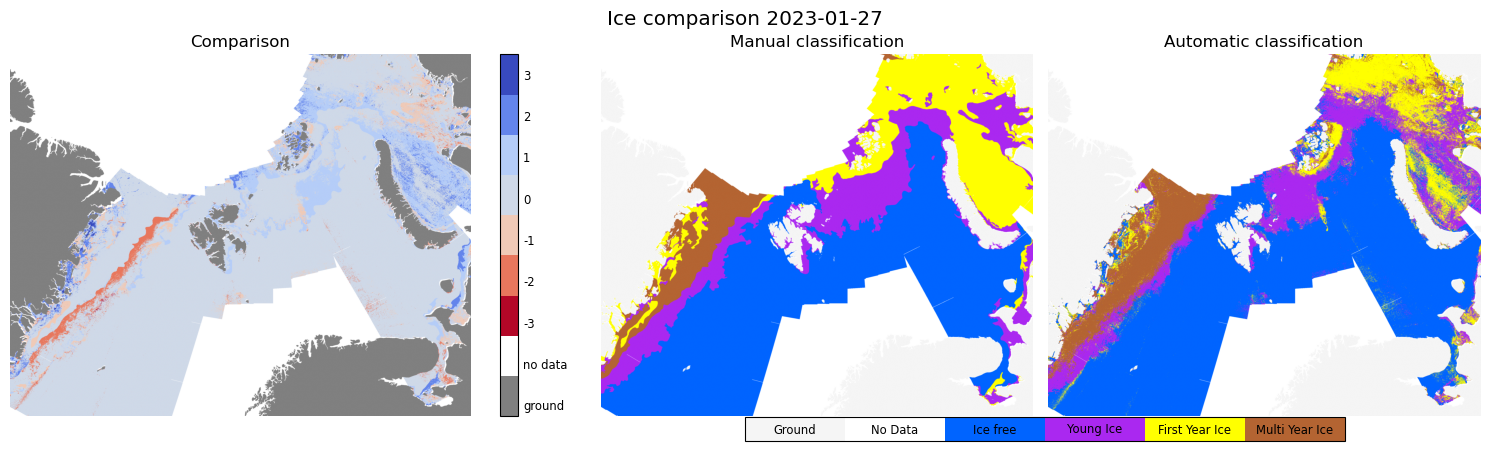

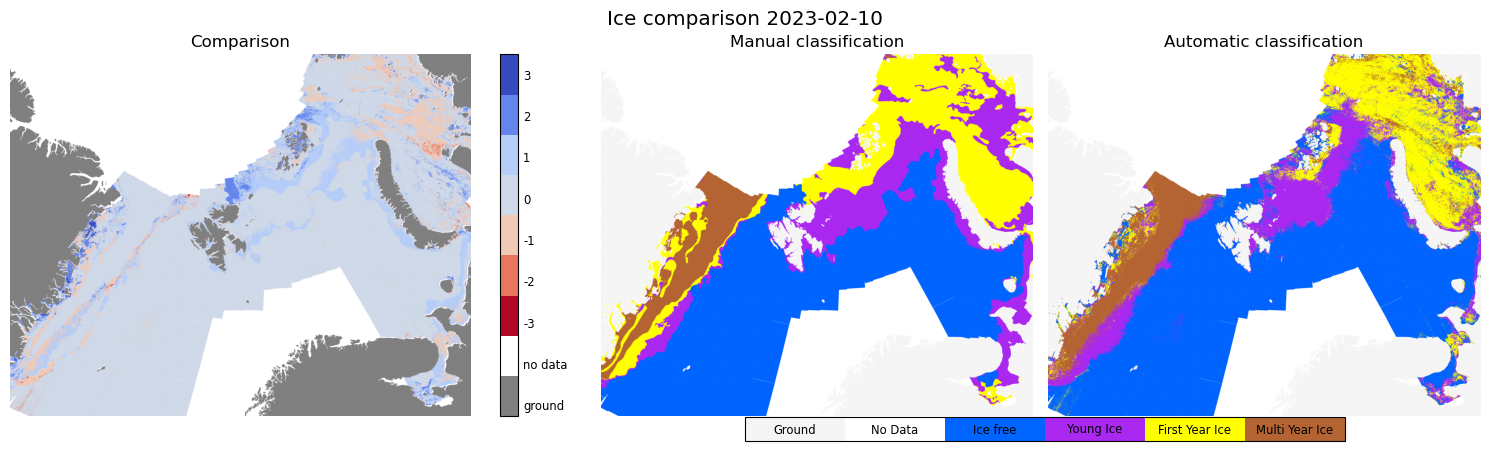

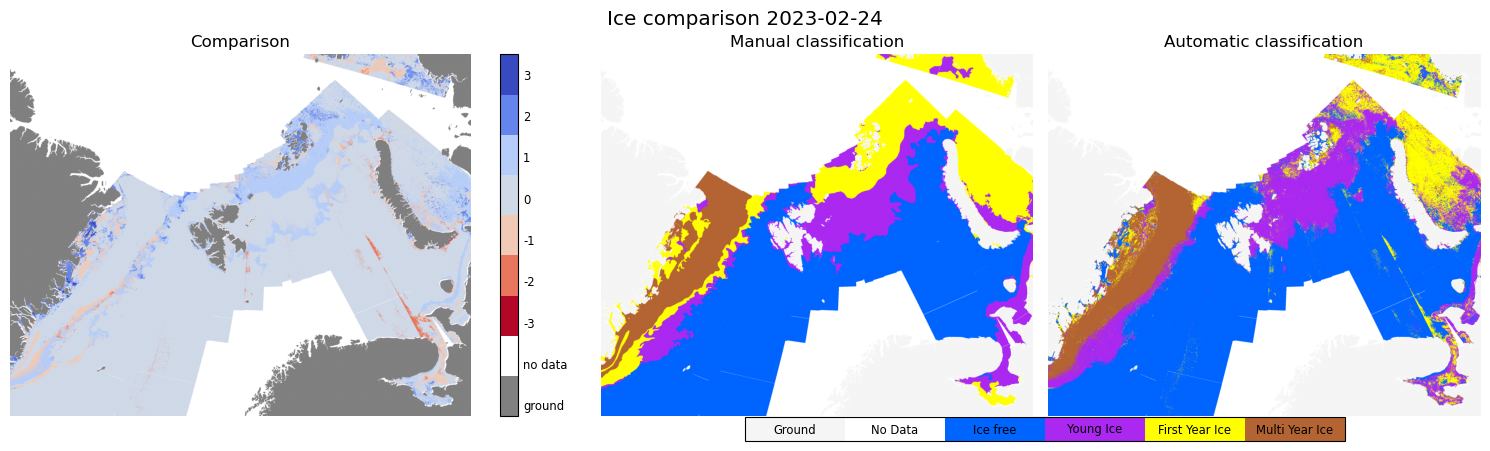

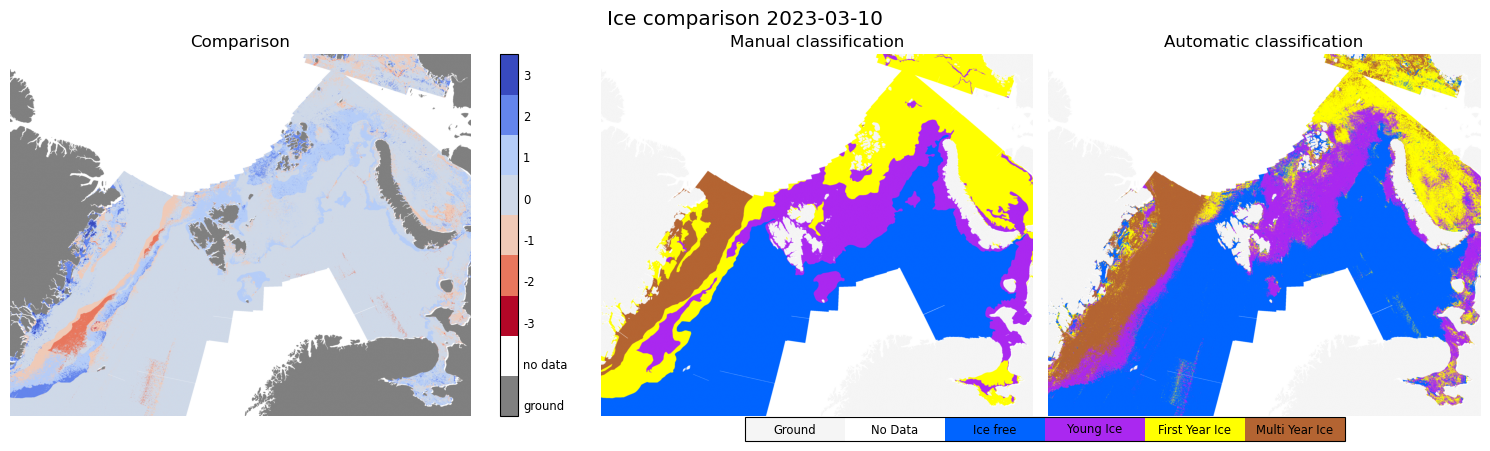

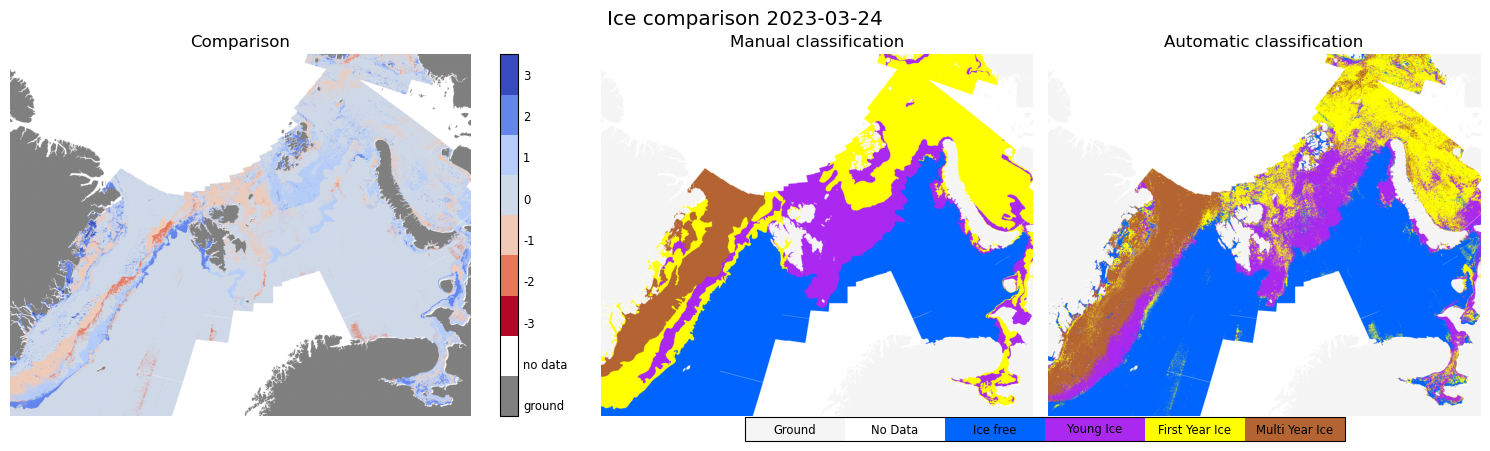

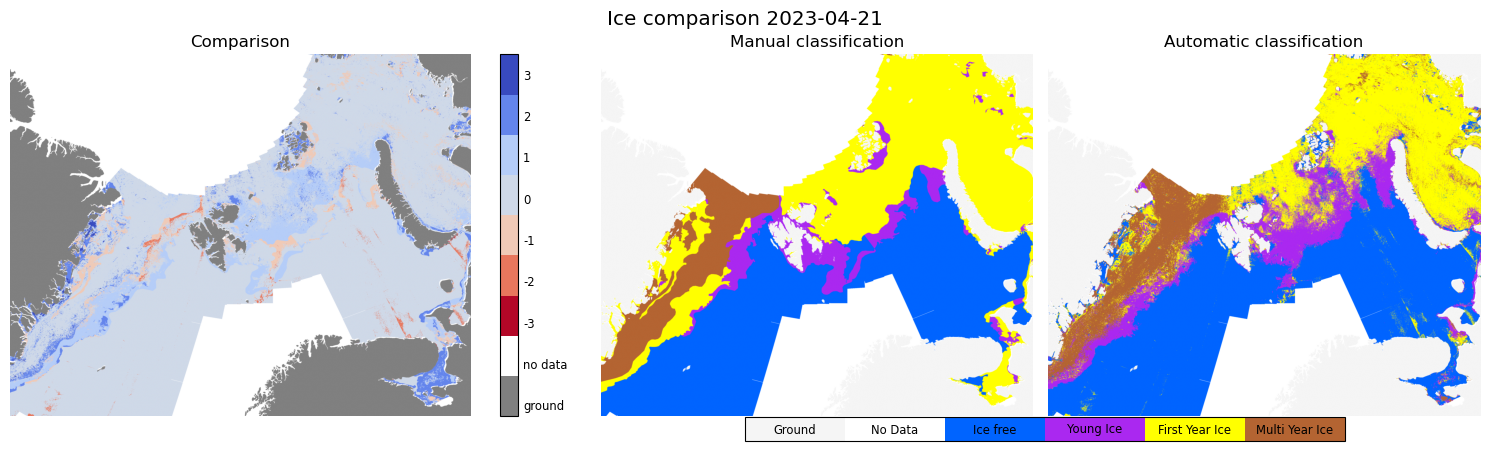

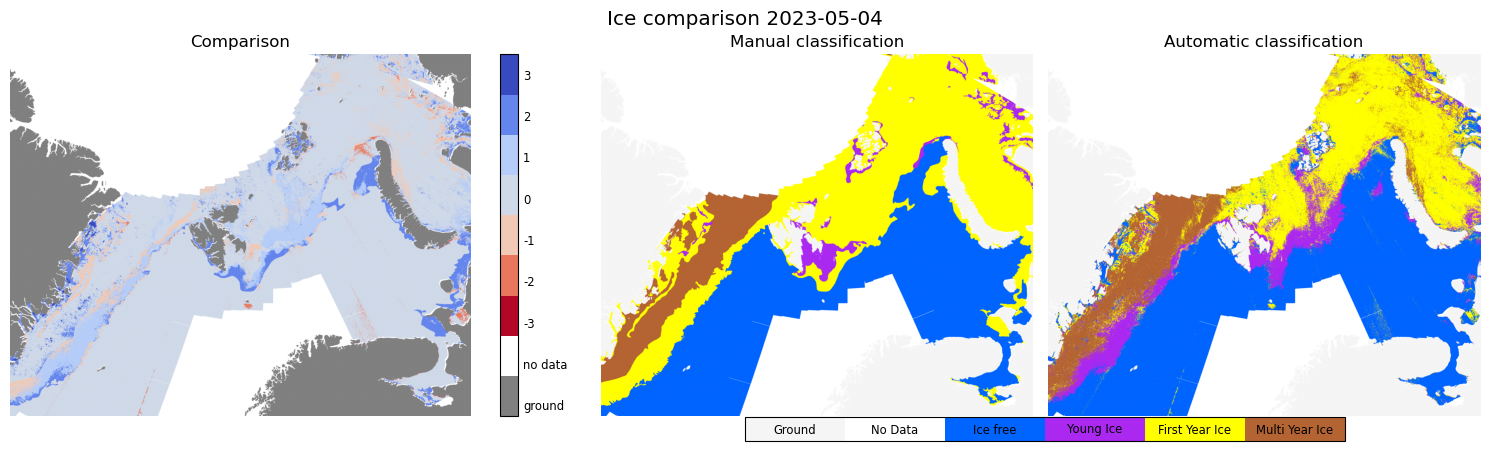

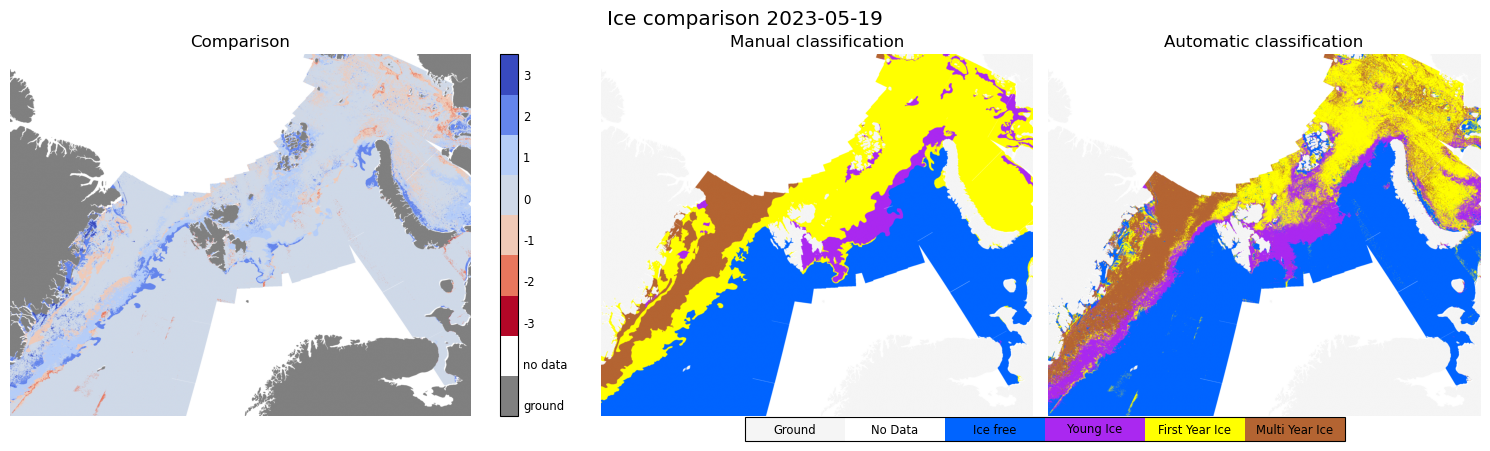

In [13]:
#start_date = date(2023, 1, 1)
#end_date = date(2023, 5, 31)

#pf_man = '/home/malela/dl_test/NIC/'
#pf_aut = '/Data/sat/auxdata/ice_charts/NERSC/nrt.cmems-du.eu/Core/SEAICE_ARC_PHY_AUTO_L4_NRT_011_015/cmems_obs-si_arc_phy-icetype_nrt_L4-auto_P1D/'
#pf_stats = '/home/malela/data/nic_nersc/'

#nic_nersc_comparison(start_date, end_date, pf_man, pf_aut, pf_stats)

In [6]:

parser = argparse.ArgumentParser()
parser.add_argument("start", help="start date of computation YYYY-mm-dd")
parser.add_argument("end", help="end date of computation YYYY-mm-dd")
parser.add_argument("path_man", help="path of manuals data /path/to/data/")
parser.add_argument("path_aut", help="path of automatics data /path/to/data/")
parser.add_argument("path_stats", help="path of statistics results and images /path/to/data/")
args = parser.parse_args()

istart = args.start
istart = istart.split('-')
start_date = date(int(istart[0]), int(istart[1]), int(istart[2]))
iend = args.end
iend = iend.split('-')
end_date = date(int(iend[0]), int(iend[1]), int(iend[2]))

nic_nersc_comparison(start_date, end_date, args.path_man, args.path_aut, args.path_stats)

usage: ipykernel_launcher.py [-h] start end path_man path_aut path_stats
ipykernel_launcher.py: error: the following arguments are required: end, path_man, path_aut, path_stats


SystemExit: 2